<a href="https://colab.research.google.com/github/WinterBlue16/Data_contest/blob/master/DACON/DACON(Oct)_Baseline2_hyperparamtune_0929.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HAI 2.0 Baseline Model 

In [ ]:
# 파일 압축 풀기
# !!unzip -uq "/content/drive/My Drive/dacon/security_dataset/data.zip" -d "/content/drive/My Drive/dacon/security_dataset/"

[]

In [1]:
# TaPR 설치
!pip install -q '/content/drive/My Drive/dacon/security_dataset/HAI 1.0/eTaPR-1.12-py3-none-any.whl'

In [2]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from TaPR_pkg import etapr

## 데이터 전처리

In [3]:
TRAIN_DATASET = sorted([x for x in Path("/content/drive/My Drive/dacon/security_dataset/HAI 2.0/training").glob("*.csv")])
TRAIN_DATASET

[PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/training/train1.csv'),
 PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/training/train2.csv'),
 PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/training/train3.csv')]

In [4]:
TEST_DATASET = sorted([x for x in Path("/content/drive/My Drive/dacon/security_dataset/HAI 2.0/testing").glob("*.csv")])
TEST_DATASET

[PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/testing/test1.csv'),
 PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/testing/test2.csv'),
 PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/testing/test3.csv'),
 PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/testing/test4.csv')]

In [5]:
VALIDATION_DATASET = sorted([x for x in Path("/content/drive/My Drive/dacon/security_dataset/HAI 2.0/validation").glob("*.csv")])
VALIDATION_DATASET

[PosixPath('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/validation/validation.csv')]

In [6]:
def dataframe_from_csv(target):
  return pd.read_csv(target).rename(columns=lambda x:x.strip())

def dataframe_from_csvs(targets):
  return pd.concat([dataframe_from_csv(x) for x in targets])

In [7]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW # c02, c03, c14, c18, c19, c21, c22, c28, c33, c34, c35, c40, c43, c41, c48, c51, c52, c59, c63, c67, c71

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,-3.0660,-0.00297,301.01636,40.49072,10,1000.44769,397.63785,4795.0,0,1,16495.0,0,1,4.01474,15454.0,763.19324,246.43968,8.46252,0,1.29784,35.74219,1973.19031,10052.0,10,1,1,100.0,10,1001.99799,37.14706,0,100.0,815.0,20,4.1758,166.74039,11.89504,54074.0,0,780.0,608.0,1,0,-0.00072,100.0,51.58201,2847.02539,0.27786,0.06511,70,2847.02539,540833,712.07275,540833,1,2880,39.09198,0,0.10121,27610.0,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,-2.9721,0.00072,297.43567,40.49072,10,1000.01270,397.63785,4835.0,0,1,16402.0,0,1,3.74347,15461.0,763.19324,246.43968,8.47015,0,1.29692,35.74219,1975.47900,10052.0,10,1,1,100.0,10,1001.99799,37.14477,0,100.0,883.0,20,3.9259,168.64778,11.93421,54089.0,0,781.0,528.0,1,0,-0.00051,100.0,51.60648,2839.58520,0.27634,0.04340,70,2839.58520,540833,708.52661,540833,1,2880,39.05680,0,0.10121,27610.0,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,-2.9857,-0.00145,298.84619,40.49835,10,1000.88245,397.63785,4961.0,0,1,16379.0,0,1,3.43603,15462.0,763.19324,246.05821,8.47015,0,1.29631,35.74219,1972.42725,10050.0,10,1,1,100.0,10,1001.99799,37.14325,0,100.0,956.0,20,3.6489,168.83849,11.97030,54124.0,0,780.0,464.0,1,0,-0.00043,100.0,51.57790,2833.26807,0.27634,0.04340,70,2833.26807,540833,709.15527,540833,1,2880,38.97124,0,0.10121,27617.0,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,-3.2166,-0.00318,297.74310,40.49072,10,1000.88245,397.63785,5022.0,0,1,16422.0,0,1,3.12860,15466.0,763.19324,246.63045,8.46252,0,1.28685,35.74219,1983.10828,10052.0,10,1,1,100.0,10,1001.99799,37.11959,0,100.0,992.0,20,3.3040,170.55510,12.01066,54099.0,0,780.0,416.0,1,0,-0.00072,100.0,51.58236,2834.95264,0.27634,0.02170,70,2834.95264,540833,715.46631,540833,1,2880,38.94103,0,0.10121,27614.0,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,-3.5613,0.00015,297.01965,40.49835,10,1000.01270,397.63785,5088.0,0,1,16355.0,0,1,2.87546,15461.0,763.19324,246.24898,8.47015,0,1.28807,35.74219,1986.16016,10052.0,10,1,1,100.0,10,1001.99799,37.12265,0,100.0,1074.0,20,3.1881,171.31805,11.99684,54094.0,0,782.0,368.0,1,0,-0.00051,100.0,51.62335,2832.70654,0.27710,0.02170,70,2832.70654,540833,709.22852,540833,1,2880,38.90300,0,0.10121,27621.0,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,2020-08-10 10:59:56,387.27219,12,10,66.72057,-0.9331,-1.84479,781.87915,28.02389,880.0,-2.6936,0.00130,359.39307,52.49939,10,1107.37695,386.60074,-22.0,0,1,17069.0,0,1,64.86902,16460.0,763.19324,309.02856,15.00092,0,1.36711,35.34546,1958.69434,10027.0,10,1,1,100.0,10,1109.47327,35.66360,0,100.0,-20.0,20,4.6991,219.95543,11.92414,54121.0,0,782.0,13728.0,1,0,0.00022,100.0,66.63997,2830.03906,0.27557,62.55063,70,2825.96826,540833,716.41846,540833,1,2880,52.09266,0,0.10167,27586.0,944.84705,0.0,1.32843,15.17817,

In [8]:
TRAIN_DF_RAW['C14'].value_counts()
# del TRAIN_DF_RAW['C02']

10    921603
Name: C14, dtype: int64

In [9]:
# # column 추가
# COL = TRAIN_DF_RAW.loc[:, 'C01':'C79']
# TRAIN_DF_RAW['C80'] = COL.mean(axis=1)
# TRAIN_DF_RAW

In [10]:
TIMESTAMP_FIELD = "time" # 시간 column
IDSTAMP_FIELD = "id" # id column
ATTACK_FIELD = "attack" # attack column

VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD]) # 시간 column 제거
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

In [11]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [12]:
def normalize(df):
  ndf = df.copy()
  for c in df.columns:
    if TAG_MIN[c] == TAG_MAX[c]:
      ndf[c] = df[c] - TAG_MIN[c]
    else:
      ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])

  return ndf

In [13]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.81).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,0.481272,0.260132,0.200820,0.0,0.478068,0.357101,0.881536,0.0,0.0,0.270592,0.0,0.0,0.045701,0.708779,0.0,0.406877,0.289495,0.0,0.317237,0.139665,0.983325,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661946,0.0,1.0,0.215404,0.0,0.642237,0.373146,0.444904,0.465909,0.0,0.392405,0.047904,0.0,0.0,0.574348,1.0,0.206193,0.996286,0.049420,0.000870,0.0,0.996286,0.0,0.480318,0.0,0.0,0.0,0.189004,0.0,0.989609,0.808081,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378538,0.0,0.0,0.226632,0.354943,0.000166,0.398140,0.367905,0.793383,0.538081,0.511439,0.248931,0.200820,0.0,0.476771,0.357101,0.887681,0.0,0.0,0.265127,0.0,0.0,0.043071,0.709179,0.0,0.406877,0.289722,0.0,0.316537,0.139665,0.984286,0.331731,0.0,0.0,0.0,1.0,0.0,0.482697,0.661514,0.0,1.0,0.230075,0.0,0.565589,0.376426,0.553728,0.513655,0.0,0.403042,0.044310,0.0,0.0,0.576421,1.0,0.206915,0.994079,0.048833,0.000651,0.0,0.994079,0.0,0.455772,0.0,0.0,0.0,0.188610,0.0,0.989609,0.808081,0.591503,0.0,0.326835,0.254343,0.336759,0.916661,0.266988,0.252792,1.00000,0.516304
2,0.378473,0.0,0.0,0.226777,0.322226,0.000156,0.393659,0.444105,0.802839,0.538513,0.498896,0.251477,0.200903,0.0,0.479086,0.357101,0.907420,0.0,0.0,0.262969,0.0,0.0,0.039770,0.709297,0.0,0.404742,0.289757,0.0,0.315979,0.139665,0.983192,0.327810,0.0,0.0,0.0,1.0,0.0,0.482697,0.661168,0.0,1.0,0.247634,0.0,0.471253,0.377253,0.667906,0.629182,0.0,0.394367,0.040962,0.0,0.0,0.577508,1.0,0.206208,0.991918,0.048742,0.000617,0.0,0.991918,0.0,0.456192,0.0,0.0,0.0,0.187620,0.0,0.989609,0.865749,0.595094,0.0,0.326429,0.255216,0.337639,0.916661,0.265447,0.254616,1.00000,0.474417
3,0.378862,0.0,0.0,0.226804,0.247357,0.000154,0.393727,0.334553,0.812552,0.467318,0.482945,0.248614,0.200835,0.0,0.479511,0.357101,0.920084,0.0,0.0,0.265011,0.0,0.0,0.036287,0.709540,0.0,0.407535,0.289544,0.0,0.308933,0.139665,0.987319,0.330990,0.0,0.0,0.0,1.0,0.0,0.482697,0.656791,0.0,1.0,0.258351,0.0,0.351853,0.380253,0.797067,0.573563,0.0,0.392776,0.038267,0.0,0.0,0.574945,1.0,0.206206,0.992004,0.048725,0.000399,0.0,0.992004,0.0,0.498430,0.0,0.0,0.0,0.187112,0.0,0.989609,0.851747,0.596008,0.0,0.326355,0.257141,0.332316,0.916661,0.264501,0.253156,1.00000,0.449499
4,0.380136,0.0,0.0,0.226809,0.174704,0.000154,0.410896,0.623321,0.821887,0.347591,0.506182,0.245891,0.200906,0.0,0.477091,0.357101,0.932250,0.0,0.0,0.261602,0.0,0.0,0.033263,0.709310,0.0,0.405942,0.289723,0.0,0.308497,0.139665,0.989333,0.331590,0.0,0.0,0.0,1.0,0.0,0.482697,0.656522,0.0,1.0,0.277430,0.0,0.295044,0.382085,0.784427,0.547721,0.0,0.412987,0.035679,0.0,0.0,0.576460,1.0,0.207372,0.991377,0.049005,0.000358,0.0,0.991377,0.0,0.464774,0.0,0.0,0.0,0.186606,0.0,0.989609,0.906391,0.598475,0.0,0.326744,0.256375,0.336790,0.916661,0.262942,0.248263,1.00000,0.474986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302371,0.0,0.0,0.703684,0.506324,0.000538,0.425475,0.372606,0.065052,0.626180,0.520307,0.481316,0.362090,0.0,0.857891,0.215741,0.000920,0.0,0.0,0.313680,0.0,0.0,0.749132,0.777869,0.0,0.836238,0.521024,0.0,0.380241,0.066590,0.976925,0.271288,0.0,0.0,0.0,1.0,0.0,0.946227,0.328677,0.0,1.0,0.001028,0.0,0.846639,0.482552,0.518359,0.628875,0.0,0.426737,0.750362,0.0,0.0,0.584935,1.0,0.734757,0.989966,0.048365,0.754140,0.0,0.988587,0.0,0.507750,0.0,0.0,0.0,0.362081,0.0,0.995982,0.560466,0.682706,0

In [14]:
# # column 추가
# COL = TRAIN_DF.loc[:, 'C01':'C79']
# TRAIN_DF['C80'] = COL.mean(axis=1)

# # VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF.columns # 시간 column 제거
# # VALID_COLUMNS_IN_TRAIN_DATASET

# TRAIN_DF

In [15]:
def boundary_check(df):
  x = np.array(df, dtype=np.float32)
  return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [16]:
boundary_check(TRAIN_DF)

(False, False, False)

## 학습 모델 설정 & 데이터 입출력 정의

In [17]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90

class HaiDataset(Dataset):
  def __init__(self, timestamps, df, stride=1, attacks=None):
    self.ts = np.array(timestamps) # 시간 column을 np.array 자료형으로 변환 
    self.tag_values = np.array(df, dtype=np.float32) # 전체 dataframe을 np.array로 변환
    self.valid_idxs = [] # index가 들어갈 list 만들기
    
    for L in trange(len(self.ts) - WINDOW_SIZE + 1): # 0부터 (시간 column 길이 - 91)
      R = L + WINDOW_SIZE - 1 # 89
      if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(self.ts[L]) == timedelta(seconds=WINDOW_SIZE - 1): # 시간 column의 특정값(index R, L) 차가 89초 전의 값과 같을 경우
        self.valid_idxs.append(L) # index에 L 값을 추가

    self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]# valid_idx를 np.array 자료형으로 변환(int32)
    self.n_idxs = len(self.valid_idxs) # n_idxs는 valid_idxs의 길이를 나타냄
    print(f"# of valid windows: {self.n_idxs}")

    if attacks is not None: # 공격(attacks)이 None이 아닐 경우 = 공격이 들어왔을 경우
      self.attacks = np.array(attacks, dtype=np.float32) # attacks를 np.array 자료형으로 변환(float32)
      self.with_attack = True # with_attack을 True로 지정
    
    else: # 공격이 None일 경우 = 공격이 들어오지 않았을 경우
      self.with_attack = False # with_attack을 False로 지정

  def __len__(self):
    return self.n_idxs # n_idxs 반환

  def __getitem__(self, idx):
    i = self.valid_idxs[idx] # valid_idxs에서 index가 idx인 np.array 자료형의 값을 꺼냄
    last = i + WINDOW_SIZE - 1 # +89
    item = {"attack": self.attacks[last]} if self.with_attack else {} # self.with_attack이 True일 경우 self.attacks에서 index가 last인 값을 꺼내 item column으로 지정
    item["ts"] = self.ts[i + WINDOW_SIZE - 1] # item column 추가
    item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN]) # item column 추가(input 값)
    item["answer"] = torch.from_numpy(self.tag_values[last]) # item column 추가(정답값)
    return item  



In [18]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=1)
HAI_DATASET_TRAIN[0]


# of valid windows: 921336


{'answer': tensor([3.7400e-01, 0.0000e+00, 0.0000e+00, 2.2681e-01, 4.4636e-01, 1.5360e-04,
         3.0701e-01, 5.9155e-01, 4.2073e-01, 4.9937e-01, 5.1549e-01, 4.5781e-01,
         1.4508e-01, 0.0000e+00, 4.7905e-01, 3.5710e-01, 1.1306e-03, 0.0000e+00,
         0.0000e+00, 3.8905e-01, 0.0000e+00, 0.0000e+00, 2.0921e-04, 9.5672e-01,
         0.0000e+00, 4.0752e-01, 3.6943e-01, 0.0000e+00, 4.1255e-01, 1.3958e-01,
         9.8395e-01, 2.6923e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.8270e-01, 7.2113e-01, 0.0000e+00, 1.0000e+00, 1.2501e-01,
         0.0000e+00, 6.5788e-01, 3.7976e-01, 3.4929e-01, 5.3711e-01, 0.0000e+00,
         3.0564e-01, 2.5663e-03, 0.0000e+00, 0.0000e+00, 5.8361e-01, 1.0000e+00,
         2.2821e-01, 9.9258e-01, 4.8665e-02, 0.0000e+00, 0.0000e+00, 9.9258e-01,
         0.0000e+00, 4.7910e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5513e-01,
         0.0000e+00, 9.8961e-01, 8.3952e-01, 5.9668e-01, 0.0000e+00, 2.8125e-01,
         3.3977e-0

In [19]:
N_HIDDENS = 105
N_LAYERS = 3
BATCH_SIZE = 512

class StackedGRU(torch.nn.Module):
  def __init__(self, n_tags):
    super().__init__()
    self.rnn = torch.nn.GRU(
        input_size=n_tags,
        hidden_size=N_HIDDENS,
        num_layers=N_LAYERS,
        bidirectional=True,
        dropout=0,
    )
    self.fc=torch.nn.Linear(N_HIDDENS * 2, n_tags)

  def forward(self, x):
    x = x.transpose(0, 1) # (batch, seq, params) -> (seq, batch, params)
    self.rnn.flatten_parameters()
    outs,_ = self.rnn(x)
    out = self.fc(outs[-1])
    return x[0] + out

In [20]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(79, 105, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=210, out_features=79, bias=True)
)

## 신규 모델 학습

In [21]:
def train(dataset, model, batch_size, n_epochs):
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
  optimizer = torch.optim.AdamW(model.parameters())
  loss_fn = torch.nn.MSELoss()
  epochs = trange(n_epochs, desc="training")
  best = {"loss" : sys.float_info.max}
  loss_history = []

  for e in epochs:
    epoch_loss = 0
    for batch in dataloader:
      optimizer.zero_grad()
      given = batch["given"].cuda()
      guess = model(given)
      answer = batch["answer"].cuda()
      loss = loss_fn(answer, guess)
      loss.backward()
      epoch_loss += loss.item()
      optimizer.step()
    loss_history.append(epoch_loss)
    epochs.set_postfix_str(f"loss: {epoch_loss: .6f}")
    if epoch_loss < best["loss"]:
      best["state"] = model.state_dict()
      best["loss"] = epoch_loss
      best["epoch"] = e + 1
  return best, loss_history

In [98]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 32) # 40은 오히려 정확도가 크게 떨어짐


CPU times: user 1h 14min 36s, sys: 18min 18s, total: 1h 32min 54s
Wall time: 1h 33min 14s


In [99]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]
# loss 값이 낮고, epoch은 32가 되어야 한다.
# (0.4412783420557389, 31)
# (0.4188706115965033, 32) # 105
# (0.4056496938719647, 32) # 107
# (0.4194745959248394, 31) # 106
# # 106 # 훈련 중 loss가 낮아지다가 다시 올라가기 시작한다(과적합 의심)

(0.3984421229106374, 32)

In [100]:
with open("/content/drive/My Drive/dacon/security_dataset/HAI 2.0/model_batchsize512_0.81_104.pt", "wb") as f:
  torch.save(
      {
          "state": BEST_MODEL["state"],
       "best_epoch" : BEST_MODEL["epoch"],
       "loss_history" : LOSS_HISTORY,
      },
      f
  )

## 모델 불러오기

In [43]:
with open("/content/drive/My Drive/dacon/security_dataset/HAI 2.0/model_batchsize512_0.81_105.pt", "rb") as f:
  SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL['state'])

<All keys matched successfully>

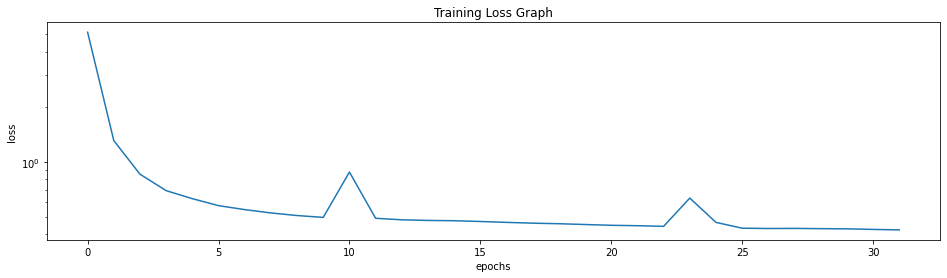

In [44]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

## 학습된 모델을 이용한 탐지

In [45]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,...,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,-2.8687,0.00470,464.06610,41.32233,10,989.14117,403.78854,-25.0,0,1,20469.0,0,1,73.58581,18082.0,763.19324,243.38802,10.84290,0,1.58771,35.14710,1978.72156,10044.0,10,1,1,100.00000,10,985.37353,36.81010,...,99.91608,-23.0,20,3.7751,176.08643,11.91040,54116.0,0,790.0,15888,1,0,0.00029,100.00000,50.90726,2843.37549,0.27557,76.80121,70,2839.58520,540833,725.21362,540833,1,2880,40.74125,0,0.10178,27567.0,845.69550,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,-2.9842,0.00210,464.22888,41.32233,10,992.62018,403.78854,-25.0,0,1,20489.0,0,1,73.89325,18043.0,763.19324,243.00656,10.84290,0,1.58725,35.14710,1986.92322,10040.0,10,1,1,100.00000,10,985.37353,36.80895,...,99.91608,-23.0,20,3.1689,173.79756,11.98856,54114.0,0,789.0,15952,1,0,0.00051,100.00000,50.74607,2845.06006,0.27710,76.92419,70,2843.37549,540833,721.74072,540833,1,2880,40.86124,0,0.10178,27564.0,840.47705,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,-3.4939,0.00130,466.90533,41.32233,10,993.92468,403.78854,-25.0,0,1,20604.0,0,1,74.20068,18024.0,763.19324,242.81586,10.84290,0,1.59519,35.14710,1978.72156,10037.0,10,1,1,100.00000,10,985.37353,36.82879,...,99.91608,-23.0,20,2.9615,174.56052,11.97400,54082.0,0,786.0,16000,1,0,0.00022,100.00000,50.66229,2837.33911,0.27710,77.04715,70,2845.06006,540833,718.15796,540833,1,2880,41.02906,0,0.10178,27565.0,835.25842,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,-3.8188,0.00000,466.79688,41.32233,10,993.05493,403.78854,-25.0,0,1,20633.0,0,1,74.43579,17985.0,763.19324,242.43439,10.84290,0,1.59747,35.14710,1977.76782,10040.0,10,1,1,100.00000,10,985.37353,36.83451,...,99.91608,-23.0,20,3.1285,176.65860,11.92999,54109.0,0,785.0,16064,1,0,0.00022,100.00000,50.66462,2843.37549,0.27557,77.17014,70,2837.33911,540833,716.38794,540833,1,2880,41.15958,0,0.10178,27560.0,836.99799,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,-3.9858,-0.00043,467.88190,41.21552,10,992.62018,403.78854,-25.0,0,1,20738.0,0,1,74.74322,17954.0,763.19324,242.81586,10.84290,0,1.59869,35.14710,1972.42725,10042.0,10,1,1,100.00000,10,985.37353,36.83756,...,99.90845,-23.0,20,3.4986,175.89565,11.86934,54111.0,0,783.0,16112,1,0,0.00000,100.00000,50.65214,2837.33911,0.27710,77.29312,70,2843.37549,540833,714.66675,540833,1,2880,41.28887,0,0.10178,27564.0,841.78162,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,-3.9067,0.00195,473.27112,98.47412,10,1116.89392,395.43826,-9.0,0,1,21044.0,0,1,77.45587,17622.0,763.19324,313.19473,15.69519,10,1.61632,35.60485,1471.74841,10053.0,10,1,1,79.42770,10,1115.26257,36.10442,...,37.21771,-21.0,20,3.1597,219.57394,11.79042,54115.0,50,787.0,16656,1,0,0.00000,37.51368,66.38953,2440.14233,0.82565,78.65308,70,2440.14233,5408

In [46]:
# del VALIDATION_DF_RAW['C02']

In [47]:
# # column 추가
# COL = VALIDATION_DF_RAW.loc[:, 'C01':'C79']
# VALIDATION_DF_RAW['C80'] = COL.mean(axis=1)
# VALIDATION_DF_RAW

In [48]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])
# column 추가
# COL = VALIDATION_DF.loc[:, 'C01':'C79']
# VALIDATION_DF['C80'] = COL.mean(axis=1)

# VALID_COLUMNS_IN_VALIDATION_DATASET = VALIDATION_DF.columns # 시간 column 제거
# VALID_COLUMNS_IN_VALIDATION_DATASET

# VALIDATION_DF

In [49]:
boundary_check(VALIDATION_DF)

(True, True, False)

In [50]:

HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 43112


{'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01, 0.0000e+00, 9.9916e-01, 2.5674e-04,
         0.0000e+00, 5.0073e-01, 3.8212e-01, 2.3146e-01, 6.1364e-01, 0.0000e+00,
         4.8101e-01, 7.6219e-01, 0.0000e+00, 0.0000e+00, 5.8022e-01, 1.0000e+00,
         1.3777e-01, 9.9420e-01, 4.8721e-02, 7.6795e-01, 0.0000e+00, 9.9123e-01,
         0.0000e+00, 4.4749e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8254e-01,
         0.0000e+00, 9.9751e-01, 3.5354e-01, 6.0346e-01, 0.0000e+00, 3.6832e-01,
         2.0053e-0

In [51]:
def inference(dataset, model, batch_size):
  dataloader = DataLoader(dataset, batch_size=batch_size)
  ts, dist, att = [], [], []
  with torch.no_grad():
    for batch in dataloader:
      given = batch["given"].cuda()
      answer = batch["answer"].cuda()
      guess = model(given)
      ts.append(np.array(batch["ts"]))
      dist.append(torch.abs(answer - guess).cpu().numpy())
      try:
        att.append(np.array(batch["attack"]))
      except:
        att.append(np.zeros(batch_size))

  return (
      np.concatenate(ts),
      np.concatenate(dist),
      np.concatenate(att),
  )

In [52]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

CPU times: user 4.04 s, sys: 1.16 s, total: 5.2 s
Wall time: 5.2 s


In [53]:
CHECK_DIST.shape

(43112, 79)

In [54]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [55]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
  l = xs.shape[0]
  chunk = l // piece
  fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
  for i in range(piece):
      L = i * chunk
      R = min(L + chunk, l)
      xticks = range(L, R)
      axs[i].plot(xticks, xs[L:R])
      if len(xs[L:R]) > 0:
          peak = max(xs[L:R])
          axs[i].plot(xticks, att[L:R] * peak * 0.3)
      if THRESHOLD!=None:
          axs[i].axhline(y=THRESHOLD, color='r')
  plt.show()

# 들여쓰기 오타

# def check_graph(xs, att, piece=2, THRESHOLD=None):
#     l = xs.shape[0]
#     chunk = l // piece
#     fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
#     for i in range(piece):
#         L = i * chunk
#         R = min(L + chunk, l)
#         xticks = range(L, R)
#         axs[i].plot(xticks, xs[L:R])
#         if len(xs[L:R]) > 0:
#             peak = max(xs[L:R])
#             axs[i].plot(xticks, att[L:R] * peak * 0.3)
#         if THRESHOLD!=None:
#             axs[i].axhline(y=THRESHOLD, color='r')
#     plt.show()

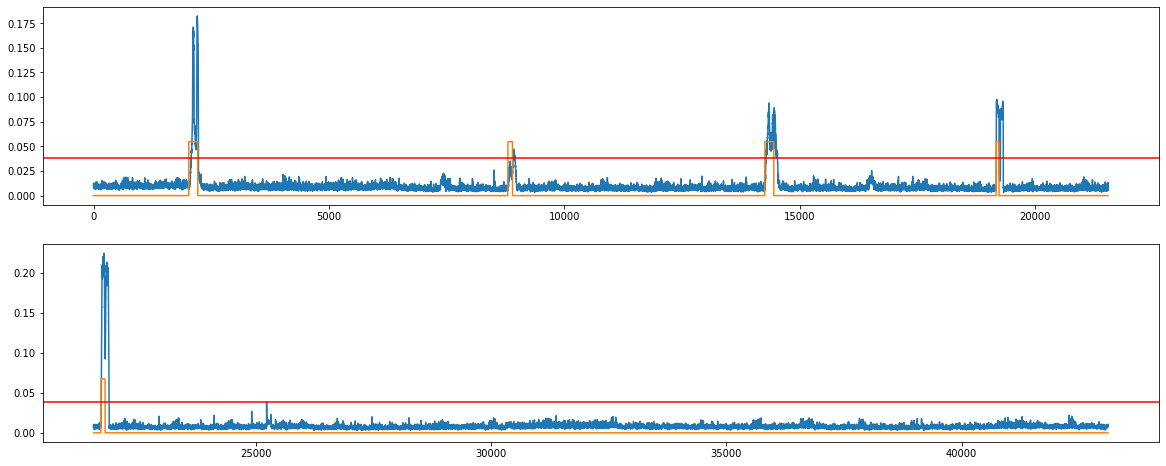

In [56]:
THRESHOLD = 0.0386
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

In [57]:
def put_labels(distance, threshold):
  xs = np.zeros_like(distance)
  xs[distance > threshold] = 1
  return xs

In [58]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (43112,))

In [59]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (43201,))

In [60]:
def fill_blank(check_ts, labels, total_ts):
  def ts_generator():
    for t in total_ts:
      yield dateutil.parser.parse(t)

  def label_generator():
    for t, label in zip(check_ts, labels):
      yield dateutil.parser.parse(t), label

  g_ts = ts_generator()
  g_label = label_generator()
  final_labels = []


  try:
    current = next(g_ts)
    ts_label, label = next(g_label)
    while True:
      if current > ts_label:
        ts_label, label = next(g_label)
        continue
      elif current < ts_label:
        final_labels.append(0)
        current = next(g_ts)
        continue
      final_labels.append(label)
      current = next(g_ts)
      ts_label, label = next(g_label)

  except StopIteration:
    return np.array(final_labels, dtype=np.int8)

In [61]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

CPU times: user 7.25 s, sys: 5.94 ms, total: 7.26 s
Wall time: 7.27 s


## 평가

In [62]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [64]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP:{TaPR['TaP']:.3f}, TaR: {TaPR['TaR']: .3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

# 0.852(0.035) => 0.866(0.039) => 0.866(0.042)

# F1: 0.866 (TaP:0.982, TaR:  0.775)
# of detected anomalies: 4
# Detected anomalies: ['1', '3', '4', '5']


# 100, 6, 512, 0.0365
# F1: 0.852 (TaP:0.963, TaR:  0.765)
# # of detected anomalies: 4
# Detected anomalies: ['1', '3', '4', '5']

# 100, 6, 512, 0.0405
# F1: 0.855 (TaP:0.982, TaR:  0.757)
# # of detected anomalies: 4
# Detected anomalies: ['1', '3', '4', '5'] # threshold가 더 커질수록 TaR이 내려가고 TaP는 올라간다.

# 100, 6, 512, 0.0398
# F1: 0.857 (TaP:0.983, TaR:  0.759)
# # of detected anomalies: 4
# Detected anomalies: ['1', '3', '4', '5']

# # 100, 3, 512, 0.0396
# F1: 0.867 (TaP:0.981, TaR:  0.776)
# # of detected anomalies: 4
# Detected anomalies: ['1', '3', '4', '5']

# # 100, 3, 512, 0.0396
# F1: 0.974 (TaP:0.987, TaR:  0.961) # TaP, TaR 동반 상승
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# # 100, 3, 512, 0.0389
# F1: 0.974 (TaP:0.987, TaR:  0.963) # TaP, TaR 동반 상승
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# 100, 3, 512, 0.0383
# F1: 0.975 (TaP:0.986, TaR:  0.964)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# 100, 3, 512, 0.0376
# F1: 0.976 (TaP:0.987, TaR:  0.966)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# 100, 3, 512, 0.0371
# F1: 0.977 (TaP:0.987, TaR:  0.967)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# C80 추가
# F1: 0.859 (TaP:0.985, TaR:  0.762)
# # of detected anomalies: 4
# Detected anomalies: ['1', '3', '4', '5']


# 100, 3, 512, 0.0391 # best!!!
# F1: 0.975 (TaP:0.987, TaR:  0.962)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# # NOT INCLUDED CO2(0.0379)
# F1: 0.928 (TaP:0.967, TaR:  0.892)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# 0.0371
# F1: 0.932 (TaP:0.966, TaR:  0.901)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# hidden 101
# F1: 0.857 (TaP:0.971, TaR:  0.768)
# # of detected anomalies: 4
# Detected anomalies: ['1', '3', '4', '5']

# hidden 105
# F1: 0.940 (TaP:0.980, TaR:  0.904)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# hidden 106
# F1: 0.072 (TaP:0.038, TaR:  1.000)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

# hidden 104
# F1: 0.940 (TaP:0.981, TaR:  0.903)
# # of detected anomalies: 5
# Detected anomalies: ['1', '2', '3', '4', '5']

F1: 0.934 (TaP:0.966, TaR:  0.904)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


## 테스트 데이터셋 예측

In [65]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)

In [66]:
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,-4.0334,-0.00231,284.39673,85.74829,10,1119.12622,382.21698,-29.0,0,1,15844.0,0,1,0.09042,18991.0,763.19324,315.48346,14.52789,0,1.25036,35.48279,1985.39734,10051.0,10,1,1,99.98731,10,1118.61084,35.37903,0,92.51556,-26.0,20,3.9907,220.14613,11.86442,54065.0,0,774.0,-224,1,0,-0.00015,92.69160,69.76647,2835.65454,0.27557,-0.00723,70,2835.65454,540833,697.39990,540833,1,2880,83.46329,0,0.09874,27600.0,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,-4.0404,-0.00181,283.47436,85.74829,10,1117.85059,382.21698,-28.0,0,1,15808.0,0,1,0.09042,18991.0,763.19324,315.10199,14.52789,0,1.24944,35.48279,1972.99939,10052.0,10,1,1,100.00000,10,1118.61084,35.37674,0,92.51556,-27.0,20,3.5714,218.23881,11.92675,54073.0,0,773.0,-224,1,0,-0.00015,92.64934,69.74272,2832.98731,0.27634,-0.00723,70,2832.98731,540833,704.41895,540833,1,2880,83.40041,0,0.09874,27600.0,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,-4.0404,0.00007,282.69678,85.74829,10,1118.48840,382.21698,-23.0,0,1,15734.0,0,1,0.09042,18991.0,763.19324,316.05570,14.52026,0,1.24746,35.48279,1981.58276,10052.0,10,1,1,99.98115,10,1118.61084,35.37178,0,92.51556,-27.0,20,3.5714,216.90367,11.92675,54073.0,0,773.0,-224,1,0,0.00007,92.91075,69.77000,2842.25244,0.27634,-0.00723,70,2842.25244,540833,704.41895,540833,1,2880,83.34054,0,0.09874,27595.0,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,-3.8861,0.00000,283.04034,85.74829,10,1117.85059,382.21698,-29.0,0,1,15710.0,0,1,0.09042,18991.0,763.19324,315.10199,14.51263,0,1.24624,35.48279,1979.86585,10053.0,10,1,1,100.00000,10,1118.61084,35.36873,0,92.51556,-27.0,20,3.3456,221.67204,11.96341,54086.0,0,777.0,-224,1,0,-0.00015,92.92407,69.70607,2833.12744,0.27557,-0.00723,70,2833.12744,540833,704.35791,540833,1,2880,83.26884,0,0.09874,27590.0,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,-3.6790,-0.00029,281.99145,85.63384,10,1119.44507,382.21698,-29.0,0,1,15608.0,0,1,0.09042,18992.0,763.19324,315.48346,14.52026,0,1.24364,35.48279,1977.19556,10052.0,10,1,1,100.00000,10,1118.61084,35.36224,0,92.51556,-26.0,20,3.2272,218.23881,11.99236,54086.0,0,778.0,-224,1,0,0.00007,93.05405,69.76971,2839.44482,0.27710,-0.00723,70,2839.44482,540833,700.89111,540833,1,2880,83.18826,0,0.09874,27588.0,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,-3.4769,-0.00231,431.51404,40.38391,10,983.98590,417.58124,-22.0,0,1,19259.0,0,1,71.14441,7140.0,763.19324,240.17335,8.83636,0,1.45290,37.89367,6.14166,10052.0,10,1,1,0.00000,10,989.50207,35.97946,0,3.39661,-20.0,20,3.9836,168.64778,11.87761,54088.0,0,787.0,15248,1,0,-0.00022,3.67038,47.56297,32.97053,0.20462,71.67969,70,31.97761,540833,705.32837,540833,1,2880,40.20410,0,0.06112,27627.0,824.82147,10

In [67]:
# del TEST_DF_RAW['C02']

In [68]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].ewm(alpha=0.81).mean())
# column 추가
# COL = TEST_DF.loc[:, 'C01':'C79']
# TEST_DF['C80'] = COL.mean(axis=1)

TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,0.487693,0.198263,0.808607,0.0,0.899123,0.159596,-0.000366,0.0,0.0,0.225073,0.0,0.0,0.000418,0.949670,0.0,0.880684,0.504186,0.0,0.274269,0.092179,0.989424,0.329327,0.0,0.0,0.0,0.999873,0.0,0.985637,0.264512,0.0,0.924960,-0.000513,0.0,0.574677,0.482436,0.343670,0.431818,0.0,0.316456,0.003422,0.0,0.0,0.581043,0.926916,0.844788,0.992272,0.048368,0.000000,0.0,0.992272,0.0,0.359459,0.0,0.0,0.0,0.779812,0.0,0.955389,0.707071,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.175737,0.000999,0.301592,0.419397,0.010417,0.137628,0.491781,0.195378,0.808607,0.0,0.895320,0.159596,-0.000212,0.0,0.0,0.222958,0.0,0.0,0.000418,0.949670,0.0,0.878484,0.504186,0.0,0.273569,0.092179,0.984219,0.331347,0.0,0.0,0.0,0.999980,0.0,0.985637,0.264079,0.0,0.924960,-0.000729,0.0,0.446072,0.479156,0.516839,0.457283,0.0,0.305819,0.003422,0.0,0.0,0.581043,0.926561,0.844087,0.991480,0.048665,0.000000,0.0,0.991480,0.0,0.408043,0.0,0.0,0.0,0.779109,0.0,0.955389,0.707071,0.680367,0.0,0.317842,0.450802,0.230809,0.944440,0.223336,0.198642,0.26162,0.654993
2,0.272910,0.0,0.0,0.828325,0.167966,0.000936,0.298931,0.432657,0.010417,0.137281,0.507331,0.192570,0.808607,0.0,0.896576,0.159596,0.000557,0.0,0.0,0.218410,0.0,0.0,0.000418,0.949670,0.0,0.883481,0.503966,0.0,0.272000,0.092179,0.986910,0.331660,0.0,0.0,0.0,0.999843,0.0,0.985637,0.263103,0.0,0.924960,-0.000763,0.0,0.426143,0.476419,0.543673,0.461229,0.0,0.304170,0.003422,0.0,0.0,0.583150,0.928638,0.844759,0.994025,0.048711,0.000000,0.0,0.994025,0.0,0.415572,0.0,0.0,0.0,0.778349,0.0,0.955389,0.665879,0.678211,0.0,0.318248,0.451198,0.229929,0.944440,0.220537,0.197059,0.26162,0.645737
3,0.273162,0.0,0.0,0.828325,0.159526,0.000987,0.348572,0.476982,0.010417,0.184847,0.509631,0.193092,0.808607,0.0,0.894971,0.159596,-0.000191,0.0,0.0,0.216215,0.0,0.0,0.000418,0.949670,0.0,0.879089,0.503706,0.0,0.270816,0.092179,0.986707,0.333667,0.0,0.0,0.0,0.999970,0.0,0.985637,0.262368,0.0,0.924960,-0.000769,0.0,0.355645,0.483831,0.646896,0.501891,0.0,0.344934,0.003422,0.0,0.0,0.581441,0.929127,0.843062,0.991879,0.048433,0.000000,0.0,0.991879,0.0,0.416545,0.0,0.0,0.0,0.777436,0.0,0.955389,0.617363,0.676029,0.0,0.318322,0.449638,0.229768,0.944440,0.219084,0.194159,0.26162,0.589420
4,0.272810,0.0,0.0,0.828325,0.172892,0.000997,0.367486,0.548481,0.010417,0.257685,0.507779,0.190027,0.807361,0.0,0.899252,0.159596,-0.000333,0.0,0.0,0.210023,0.0,0.0,0.000418,0.949725,0.0,0.880381,0.503876,0.0,0.268687,0.092179,0.985588,0.332098,0.0,0.0,0.0,0.999994,0.0,0.985637,0.261047,0.0,0.924960,-0.000562,0.0,0.307326,0.479538,0.743924,0.509566,0.0,0.362884,0.003422,0.0,0.0,0.583212,0.930272,0.844552,0.993281,0.048949,0.000000,0.0,0.993281,0.0,0.393593,0.0,0.0,0.0,0.776394,0.0,0.955389,0.591838,0.681991,0.0,0.317933,0.450775,0.229737,0.944440,0.213563,0.198446,0.26162,0.530511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619485,0.0,0.0,0.073427,0.529589,0.998079,0.477988,0.575012,0.017628,0.368509,0.490642,0.745404,0.199388,0.0,0.419045,0.612529,0.000880,0.0,0.0,0.463466,0.0,0.0,0.820150,0.142738,0.0,0.361961,0.302727,0.0,0.457420,0.533089,0.000699,0.331067,0.0,0.0,0.0,0.000000,0.0,0.428804,0.399394,0.0,0.031439,0.001027,0.0,0.535336,0.377073,0.441935,0.542673,0.0,0.483713,0.830455,0.0,0.0,0.580697,0.036762,0.065099,0.002762

In [69]:
boundary_check(TEST_DF)

(True, True, False)

In [70]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 358448


{'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01, 0.0000e+00, 9.9916e-01, 2.5674e-04,
         0.0000e+00, 5.0073e-01, 3.8212e-01, 2.3146e-01, 6.1364e-01, 0.0000e+00,
         4.8101e-01, 7.6219e-01, 0.0000e+00, 0.0000e+00, 5.8022e-01, 1.0000e+00,
         1.3777e-01, 9.9420e-01, 4.8721e-02, 7.6795e-01, 0.0000e+00, 9.9123e-01,
         0.0000e+00, 4.4749e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8254e-01,
         0.0000e+00, 9.9751e-01, 3.5354e-01, 6.0346e-01, 0.0000e+00, 3.6832e-01,
         2.0053e-0

In [71]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

CPU times: user 32.8 s, sys: 9.86 s, total: 42.7 s
Wall time: 42.7 s


In [72]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

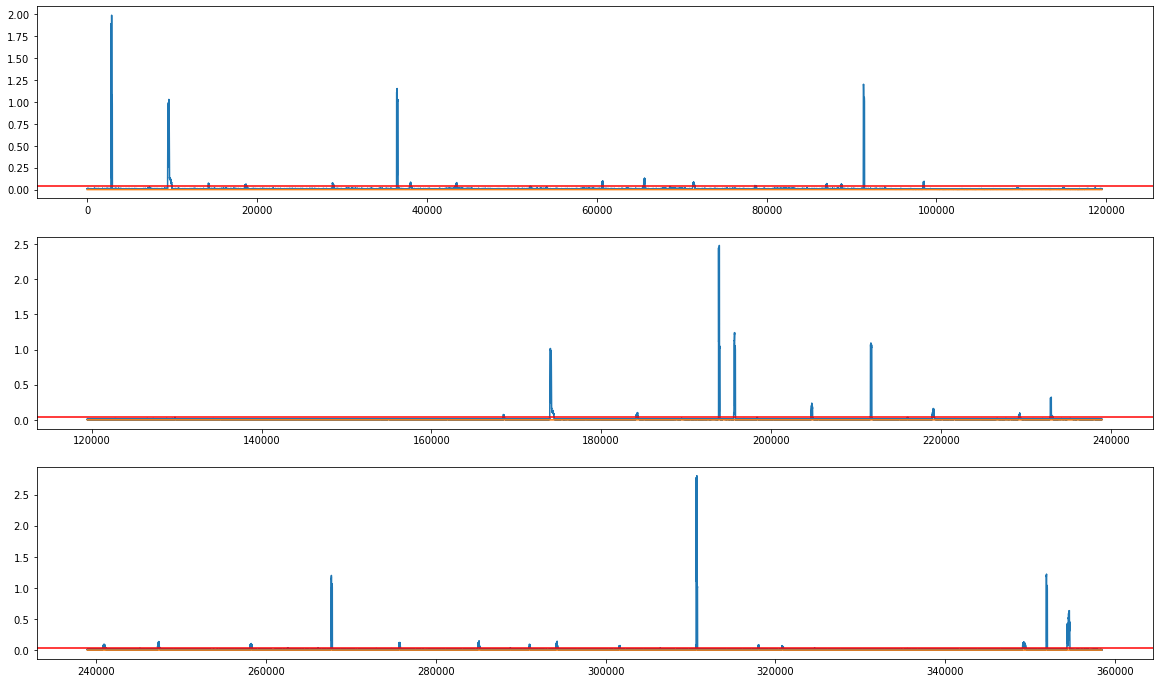

In [73]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

In [74]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (358448,))

In [75]:
submission = pd.read_csv('/content/drive/My Drive/dacon/security_dataset/HAI 2.0/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS, 'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0.0
2020-07-31 12:29:57,2020-07-31 12:29:57,0.0
2020-07-31 12:29:58,2020-07-31 12:29:58,0.0


In [76]:
submission.to_csv('/content/drive/My Drive/dacon/submission(105, 3, 512, 0.0386, 0.81, 0.81).csv', index=False)

In [ ]:
# stride=1, gru layer=4, threshold=0.04~0.054